In [1]:
# Run in python console
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/monica/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [3]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 'RT', 'edu', 'use','refugee','afghan','https','co'])

In [4]:
# Import Dataset
df = pd.read_csv('input_afghan.csv','utf-8', skipinitialspace=True, delimiter=',' )
print(df)
print(df.Sentence.unique())
#print(df)
df.head()

                   Tag                 Date  \
0     Origin: Pakistan  03-Apr-2020 05:34PM   
1     Origin: Pakistan  03-Apr-2020 05:24PM   
2     Origin: Pakistan  03-Apr-2020 05:07PM   
3     Origin: Pakistan  03-Apr-2020 05:07PM   
4     Origin: Pakistan  03-Apr-2020 04:55PM   
...                ...                  ...   
4559   Afghan refugees  04-Mar-2020 10:04AM   
4560   Afghan refugees  04-Mar-2020 12:13AM   
4561   Afghan refugees  03-Mar-2020 12:50AM   
4562   Afghan refugees  03-Mar-2020 12:09AM   
4563   Afghan refugees  03-Mar-2020 12:09AM   

                                                    URL  \
0     http://twitter.com/maxibaba/statuses/124609881...   
1     http://twitter.com/ali_ba7/statuses/1246096213...   
2     https://twitter.com/ahsan_jehangir/statuses/12...   
3     https://twitter.com/NKMalazai/statuses/1246091...   
4     https://twitter.com/Asif_Iqbal_86/statuses/124...   
...                                                 ...   
4559  http://twitter.c

,Tag,Date,URL,Unnamed: 3,Source,Country,Language,Reach,Sentence
0,Origin: Pakistan,03-Apr-2020 05:34PM,http://twitter.com/maxibaba/statuses/124609881...,NaN,Twitter,Pakistan,English,795,RT @jannamahmoud3: Palestinian youths have org...
1,Origin: Pakistan,03-Apr-2020 05:24PM,http://twitter.com/ali_ba7/statuses/1246096213...,NaN,Twitter,Pakistan,English,4062,RT @BeingNafeel: #Palestinian youths have orga...
2,Origin: Pakistan,03-Apr-2020 05:07PM,https://twitter.com/ahsan_jehangir/statuses/12...,NaN,Twitter,Pakistan,English,0,RT @DailySabah: Turkey's Diyanet Foundation la...
3,Origin: Pakistan,03-Apr-2020 05:07PM,https://twitter.com/NKMalazai/statuses/1246091...,NaN,Twitter,Pakistan,English,0,"'The coronavirus is dangerous, but hunger is m..."
4,Origin: Pakistan,03-Apr-2020 04:55PM,https://twitter.com/Asif_Iqbal_86/statuses/124...,NaN,Twitter,Pakistan,English,0,"The plight of the poor is just that, no distin..."


In [5]:
# Convert to list

df['data'] = df.Sentence.values.tolist()

df['data'] = [re.sub('\s*@\s*\s?', ' ', str(sent)) for sent in df['data']]

df['data'] = [re.sub('\?', ' ', str(sent)) for sent in df['data']]

df['data'] = [re.sub('\_', ' ', str(sent)) for sent in df['data']]

df['data'] = [re.sub('@"[\d-]"', ' ', str(sent)) for sent in df['data']]

# Remove new line characters
df['data'] = [re.sub('\s+', ' ', str(sent)) for sent in df['data']]

# Remove distracting single quotes
df['data'] = [re.sub("\'", " ", str(sent)) for sent in df['data']]

df['data']=df['data'].str.lower()
df['data'].unique()

array(['rt jannamahmoud3: palestinian youths have organized a voluntary initiative to entertain the children of gaza strip, who are in quarantine as a precaution to prevent the spread of #coronavirus, by dressing as clowns and playing at the refugee camps  streets. #act4palestine https://t.co/rrafm3sado',
       'rt beingnafeel: #palestinian youths have organized a voluntary initiative to entertain the children of #gaza strip, who are in quarantine as a precaution to prevent the spread of #coronavirus, by dressing as clowns and playing at the refugee camps  streets. https://t.co/hqrpuoqghs',
       'rt dailysabah: turkey s diyanet foundation launches covid-19 awareness campaign in rohingya refugee camps, distributes aid https://t.co/mzvg1mlb9q',
       ...,
       'iran has released 54,000 prisoners in past week - iran has the second largest outbreak of coronavirus . will we be taking refugees asylum seekers from iran . afghan refugees in greece have been trafficked through iran and ir

In [6]:
df['data'] = df['data'].apply(lambda x: [item for item in x.split() if item not in stop_words])


In [7]:
data= df['data']

In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['rt', 'jannamahmoud', 'palestinian', 'youths', 'organized', 'voluntary', 'initiative', 'entertain', 'children', 'gaza', 'strip', 'quarantine', 'precaution', 'prevent', 'spread', 'coronavirus', 'dressing', 'clowns', 'playing', 'camps', 'streets', 'act', 'palestine', 'https', 'co', 'rrafm', 'sado']]


In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['rt', 'jannamahmoud', 'palestinian_youths', 'organized_voluntary', 'initiative_entertain', 'children', 'gaza', 'strip', 'quarantine_precaution_prevent', 'spread', 'coronavirus', 'dressing_clowns_playing', 'camps', 'streets', 'act', 'palestine', 'https', 'co', 'rrafm', 'sado']


In [10]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [11]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['child', 'prevent', 'play', 'camp']]


In [12]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1)]]


In [13]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=80,
                                           alpha='auto',
                                           per_word_topics=True)

In [14]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.042*"refugee" + 0.033*"assist" + 0.031*"first" + 0.024*"concern" + '
  '0.024*"cause" + 0.024*"many" + 0.023*"report" + 0.021*"home" + '
  '0.020*"lockdown" + 0.019*"distribute"'),
 (1,
  '0.131*"drive" + 0.065*"pandemic" + 0.057*"ensure" + 0.055*"request" + '
  '0.055*"hopenotout" + 0.052*"food" + 0.051*"camp" + 0.050*"take" + '
  '0.049*"covid" + 0.048*"supply"'),
 (2,
  '0.120*"refugee" + 0.029*"country" + 0.027*"iranian" + 0.024*"health" + '
  '0.024*"migrant" + 0.022*"return" + 0.021*"fight" + 0.021*"world" + '
  '0.021*"government" + 0.018*"thousand"'),
 (3,
  '0.086*"refugee" + 0.062*"arrive" + 0.044*"must" + 0.043*"still" + '
  '0.030*"million" + 0.027*"help" + 0.027*"voanew" + 0.027*"worsen" + '
  '0.026*"covidー" + 0.025*"live"')]


In [15]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -5.274058619908953

Coherence Score:  0.4316993241463315


In [16]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.209939  0.011424       1        1  33.717556
3     -0.052249 -0.303999       2        1  25.398060
1      0.369078  0.037372       3        1  24.540222
0     -0.106889  0.255203       4        1  16.344156, topic_info=          Term         Freq        Total Category  logprob  loglift
187      drive  1806.000000  1806.000000  Default  30.0000  30.0000
945     arrive   881.000000   881.000000  Default  29.0000  29.0000
14     refugee  3881.000000  3881.000000  Default  28.0000  28.0000
188     ensure   786.000000   786.000000  Default  27.0000  27.0000
194    request   762.000000   762.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
818   hospital   118.947136   224.163635   Topic4  -4.3453   1.1776
14     refugee   387.489380  3881.824707   Topic4  -3.1643  -0.4931
514  situation   132.059631   437.634277   Topic4  -4.2407   0.6132
0         camp   134.854797   983.430786   Topic4  -4.2198  -0.1755
146      place   118.884018   768.454346   Topic4  -4.3459  -0.0549

[185 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
6         2  0.988714         aid
97        4  0.993991     already
945       2  0.998802      arrive
819       4  0.997333      assist
281       4  0.987642  assistance
...     ...       ...         ...
25        3  0.165110        work
56        1  0.997929       world
2460      1  0.002597      worsen
2460      2  0.997087      worsen
2317      1  0.996511         wup

[185 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 2, 1])

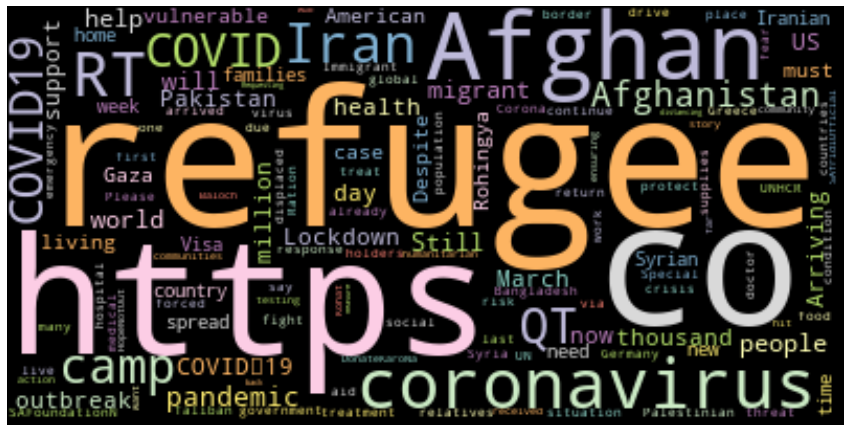

In [17]:
from wordcloud import WordCloud

from wordcloud import WordCloud, ImageColorGenerator
text = " ".join(str(each) for each in lda_model.print_topics())
wordcloud = WordCloud(max_words=200,colormap='Set3', collocations=False,background_color="black").generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='Bilinear')
plt.axis("off")
plt.figure(1,figsize=(12, 12))
plt.show()